In [2]:
from glob import glob
import os
import mne
from mne.preprocessing import annotate_muscle_zscore
from IPython.display import display, HTML
from pathlib import Path  

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
#import torch
import seaborn as sns
sns.set_theme()
mne.set_log_level("critical")


asd_file_path=sorted(glob('data/asd/*.set'))
td_file_path=sorted(glob('data/td/*.set'))

asd_files = [i for i in asd_file_path]
td_files = [i for i in td_file_path]

In [3]:
# Find bad spans of data using mne.preprocessing.annotate_muscle_zscore
def markMuscleArtifacts(raw, threshold, plot=False):
    #print("markMuscleArtifacts")
    threshold_muscle = threshold  # z-score
    annot_muscle, scores_muscle = annotate_muscle_zscore(
    raw, ch_type="eeg", threshold=threshold_muscle, min_length_good=0.2,
    filter_freq=[0, 60])
    raw.set_annotations(annot_muscle)

# Drop epochs marked as bad
def dropBadEpochs(epochs, plotLog=False):
    reject_criteria = dict(eeg=150e-6) # 150 µV
    flat_criteria = dict(eeg=1e-6) # 1 µV
    epochs.drop_bad(reject=reject_criteria, flat=flat_criteria)
    if plotLog: epochs.plot_drop_log()

# Get raw data and return cleaned version
def get_filtered_data(file_path, l_freq = 0.5, h_freq = 40, muscle_thresh = 5, interpolate={}, plot_bads=True):
    print("loading", file_path)

    # Load raw data fronm file
    raw = mne.io.read_raw_eeglab(file_path,preload=True)

    raw.set_eeg_reference()

    # Mark bad data
    markMuscleArtifacts(raw, muscle_thresh)

    # Handle Interpolation
    fileID = getFileID(file_path)
    post_interpolate_check = None
    if(fileID in interpolate):
      bad_channels = interpolate[fileID]
      post_interpolate_check = fix_bad_channels(raw, bad_channels, plot_bads)
    else: 
      post_interpolate_check = raw

    # Create even length epochs
    epochs = mne.make_fixed_length_epochs(post_interpolate_check, duration=1, overlap=0, preload=True)

    # Drop Bad Epochs
    dropBadEpochs(epochs, False)

    # Apply filter
    filtered = epochs.copy().filter(l_freq=l_freq, h_freq=h_freq)

    return filtered

def checkLeftNumbers(channel):
  return (("1" in channel) or ("3" in channel) or ("5" in channel) or ("7" in channel) or ("9" in channel)) and ("10" not in channel)

def checkRightNumbers(channel):
    return ("2" in channel) or ("4" in channel) or ("6" in channel) or ("8" in channel) or ("10" in channel)

def getFrontalChannels(raw):
  _channels = [i for i in raw.ch_names if "F" in i and "C" not in i]
  return raw.copy().pick_channels(_channels)

def getCentralChannels(raw):
  _channels = [i for i in raw.ch_names if "C" in i and "F" not in i]
  return raw.copy().pick_channels(_channels)

def getPosteriorChannels(raw):
  _channels = [i for i in raw.ch_names if ("P" in i or "O" in i) and "C" not in i]
  return raw.copy().pick_channels(_channels) 

def getLeftChannels(raw):
  _channels = [i for i in raw.ch_names if checkLeftNumbers(i)]
  return raw.copy().pick_channels(_channels) 

def getRightChannels(raw):
  _channels = [i for i in raw.ch_names if checkRightNumbers(i)]
  return raw.copy().pick_channels(_channels)

def getPSD(epochs, fmax = 40):
   return epochs.compute_psd(fmax=fmax)

def fix_bad_channels(raw, bad_channels, plot_bads=True):
    raw.info["bads"] = bad_channels
    interpolated_data = raw.copy().interpolate_bads(reset_bads=False)
    #print("Bads: ", interpolated_data.info['bads'])
    if(plot_bads):
      for title, data in zip(["orig.", "interp."], [raw, interpolated_data]):
        print(title, "bands: ", bad_channels)
        with mne.viz.use_browser_backend("matplotlib"):
            fig = data.plot()
        fig.subplots_adjust(top=0.9)
        fig.suptitle(title, size="xx-large", weight="bold")

    return interpolated_data

def split(file, interpolate_channels=[]):
  raw = get_filtered_data(file, interpolate=interpolate_channels)
  frontal = getFrontalChannels(raw)
  central = getCentralChannels(raw)
  posterior = getPosteriorChannels(raw)
  left = getLeftChannels(raw)
  right = getRightChannels(raw)
  return [ frontal, central,  posterior,  left, right, raw]


interp_debug_asd_file_path=sorted(glob('data_debug/asd/*.set'))
interp_debug_td_file_path=sorted(glob('data_debug/td/*.set'))

def getFileID(fileName):
   return fileName.split('Abby')[0].split('/')[-1] #specific to test set 
'''
def interpTest(drops):
   for subject in interp_debug_td_file_path:
      fileID = getFileID(subject)
      if(fileID in drops):
         print("Drops: ", fileID, drops[fileID])
'''

'\ndef interpTest(drops):\n   for subject in interp_debug_td_file_path:\n      fileID = getFileID(subject)\n      if(fileID in drops):\n         print("Drops: ", fileID, drops[fileID])\n'

|Features|Post|Front|Left|Right|PR |PF |LR |ALL |
|--------|----|-----|----|-----|---|---|---|----|
| Delta  |52% |53%  |47% |55%  |55%|52%|57%|51% |
| Alpha  |48% |34%  |35% |44%  |47%|53%|53%|36% |
| Beta   |47% |43%  |40% |49%  |47%|51%|57%|42% |
| Theta  |50% |49%  |44% |52%  |50%|49%|58%|48% |
|Theta-Beta|49% |47%|40% |51%  |47%|51%|58%|45% |
|Theta-Delta|51%|51%|47% |55%  |53%|52%|59%|51% |
|Theta-Delta-Alpha| |    |     |   |51%|57%|    |


|Features|PF |LR |
|--------|---|---|
| Delta  |52%|57%|
| Alpha  |53%|53%|
| Beta   |51%|57%|
| Theta  |49%|58%|
|Theta-Beta  |51%|58%|
|Theta-Delta |52%|59%|
|Theta-Alpha |54%|58%|
|Theta-Delta-Alpha|51%|57%|
|Theta-Delta-Alpha-Beta|50%|57%|
|Delta-Beta|50% |58% |  
|Delta-Alpha|52%|58% |
|Beta-Alpha |50%|56% |

P/F - T/A
/////
SVC(C=5, kernel='linear')
Training acc:  0.6001893208990949
validation acc 0.7121513944223108
DecisionTreeClassifier()
Training acc:  0.5187859993516353
validation acc 0.5398406374501992
RandomForestClassifier(n_estimators=500, n_jobs=-1)
Training acc:  0.5103900031193992
validation acc 0.6155378486055777
GaussianNB()
Training acc:  0.5063262415141011
validation acc 0.6284860557768924
AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=20),
                   learning_rate=0.5, n_estimators=500)
Training acc:  0.5153505878721816
validation acc 0.548804780876494
KNeighborsClassifier(n_neighbors=4)
Training acc:  0.5320032967298726
validation acc 0.5627490039840638
LinearDiscriminantAnalysis()
Training acc:  0.5795362903865136
validation acc 0.7081673306772909
GaussianNB()
Training acc:  0.5063262415141011
validation acc 0.6284860557768924
PT/PA
/////
SVC(C=5, kernel='linear')
Training acc:  0.45629623776551453
validation acc 0.6623505976095617
DecisionTreeClass

/tmp/ipykernel_19749/4137411037.py:189: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(X[x_axis][asd_index], X[y_axis][asd_index], c="blue", cmap=plt.cm.Paired, label="ASD", alpha=0.25)
/tmp/ipykernel_19749/4137411037.py:190: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(X[x_axis][td_index], X[y_axis][td_index], c="orange", cmap=plt.cm.Paired, label="TD", alpha=0.25)


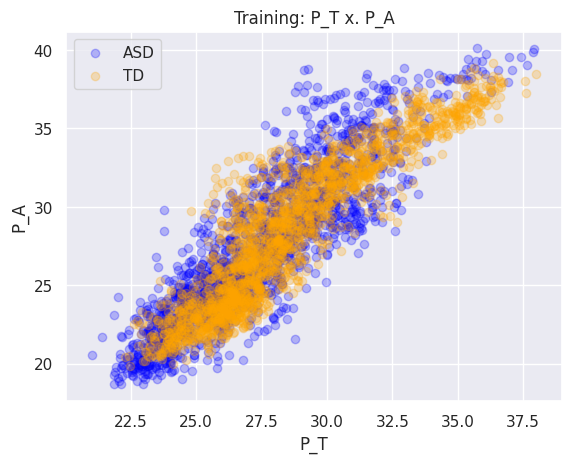

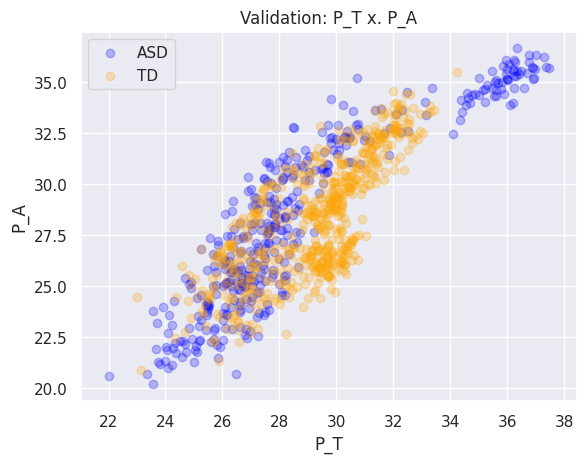

FT/FA
/////
SVC(C=5, kernel='linear')
Training acc:  0.3792484138011415
validation acc 0.646414342629482
DecisionTreeClassifier()
Training acc:  0.4645223310939926
validation acc 0.5199203187250996
RandomForestClassifier(n_estimators=500, n_jobs=-1)
Training acc:  0.4348240936955673
validation acc 0.5239043824701195
GaussianNB()
Training acc:  0.3459828023101827
validation acc 0.6145418326693227
AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=20),
                   learning_rate=0.5, n_estimators=500)
Training acc:  0.4512943079241625
validation acc 0.5119521912350598
KNeighborsClassifier(n_neighbors=4)
Training acc:  0.45218236255793914
validation acc 0.4681274900398406
LinearDiscriminantAnalysis()
Training acc:  0.39455272961525284
validation acc 0.6394422310756972
GaussianNB()
Training acc:  0.3459828023101827
validation acc 0.6145418326693227


/tmp/ipykernel_19749/4137411037.py:189: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(X[x_axis][asd_index], X[y_axis][asd_index], c="blue", cmap=plt.cm.Paired, label="ASD", alpha=0.25)
/tmp/ipykernel_19749/4137411037.py:190: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(X[x_axis][td_index], X[y_axis][td_index], c="orange", cmap=plt.cm.Paired, label="TD", alpha=0.25)


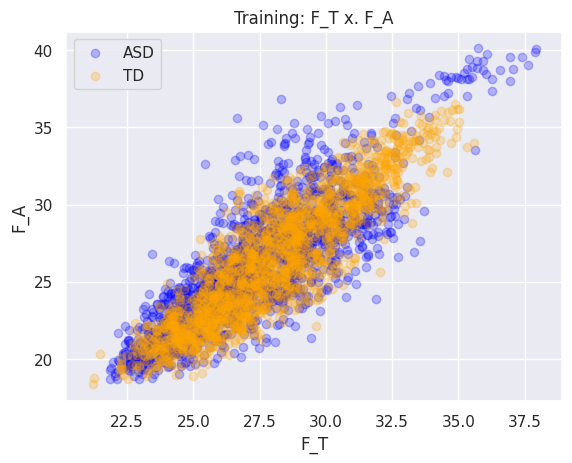

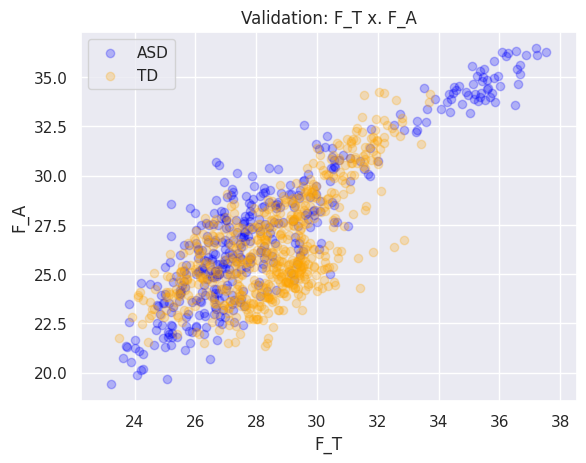

PT/FT
/////
SVC(C=5, kernel='linear')
Training acc:  0.4353297029149664
validation acc 0.6653386454183267
DecisionTreeClassifier()
Training acc:  0.5412942447604172
validation acc 0.5587649402390438
RandomForestClassifier(n_estimators=500, n_jobs=-1)
Training acc:  0.5149576032454919
validation acc 0.5856573705179283
GaussianNB()
Training acc:  0.4905904302874863
validation acc 0.6523904382470119
AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=20),
                   learning_rate=0.5, n_estimators=500)
Training acc:  0.5361158448407433
validation acc 0.5567729083665338
KNeighborsClassifier(n_neighbors=4)
Training acc:  0.5320014812125944
validation acc 0.5139442231075697
LinearDiscriminantAnalysis()
Training acc:  0.5063826030424796
validation acc 0.6683266932270916
GaussianNB()
Training acc:  0.4905904302874863
validation acc 0.6523904382470119


/tmp/ipykernel_19749/4137411037.py:189: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(X[x_axis][asd_index], X[y_axis][asd_index], c="blue", cmap=plt.cm.Paired, label="ASD", alpha=0.25)
/tmp/ipykernel_19749/4137411037.py:190: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(X[x_axis][td_index], X[y_axis][td_index], c="orange", cmap=plt.cm.Paired, label="TD", alpha=0.25)


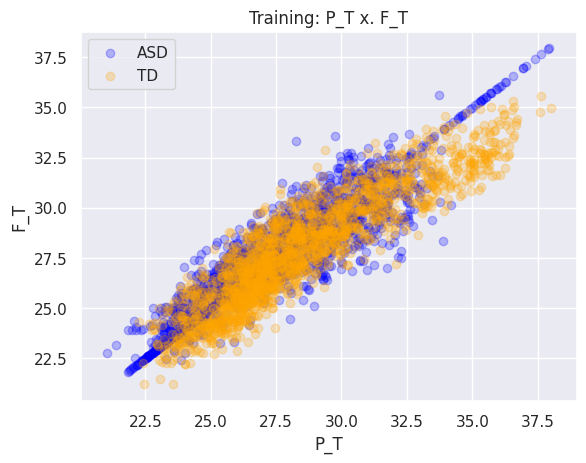

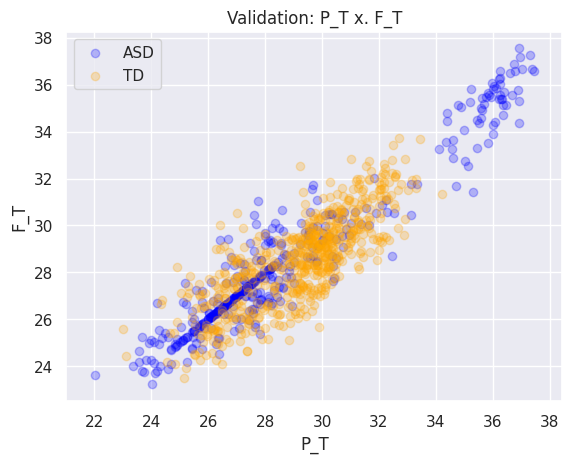

PT/FA
/////
SVC(C=5, kernel='linear')
Training acc:  0.5817792283215291
validation acc 0.6992031872509961
DecisionTreeClassifier()
Training acc:  0.4969085895065105
validation acc 0.5199203187250996
RandomForestClassifier(n_estimators=500, n_jobs=-1)
Training acc:  0.500415079725821
validation acc 0.49203187250996017
GaussianNB()
Training acc:  0.47351872862162436
validation acc 0.6314741035856574
AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=20),
                   learning_rate=0.5, n_estimators=500)
Training acc:  0.5006057547762491
validation acc 0.4900398406374502
KNeighborsClassifier(n_neighbors=4)
Training acc:  0.4920854375965762
validation acc 0.4442231075697211
LinearDiscriminantAnalysis()
Training acc:  0.5795801542393008
validation acc 0.704183266932271
GaussianNB()
Training acc:  0.47351872862162436
validation acc 0.6314741035856574


/tmp/ipykernel_19749/4137411037.py:189: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(X[x_axis][asd_index], X[y_axis][asd_index], c="blue", cmap=plt.cm.Paired, label="ASD", alpha=0.25)
/tmp/ipykernel_19749/4137411037.py:190: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(X[x_axis][td_index], X[y_axis][td_index], c="orange", cmap=plt.cm.Paired, label="TD", alpha=0.25)


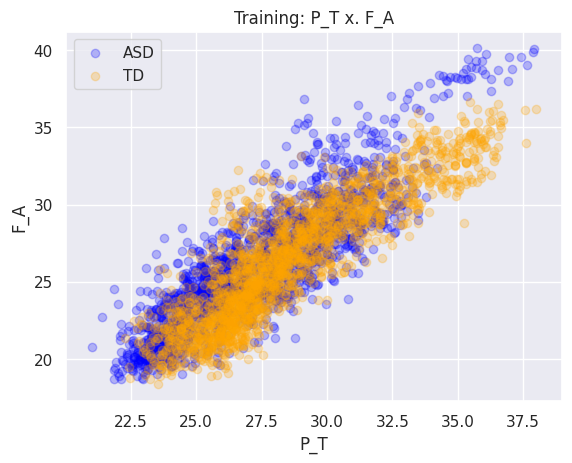

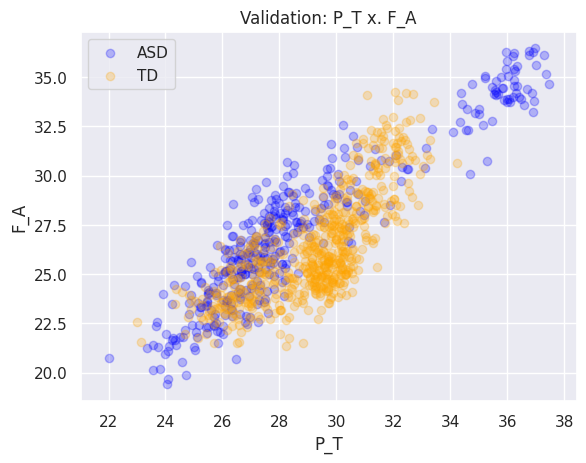

PA/FT
/////
SVC(C=5, kernel='linear')
Training acc:  0.29870291073938926
validation acc 0.5179282868525896
DecisionTreeClassifier()
Training acc:  0.48207542432426437
validation acc 0.5209163346613546
RandomForestClassifier(n_estimators=500, n_jobs=-1)
Training acc:  0.4532940493473682
validation acc 0.549800796812749
GaussianNB()
Training acc:  0.4662777469163669
validation acc 0.6334661354581673
AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=20),
                   learning_rate=0.5, n_estimators=500)
Training acc:  0.46144438130790233
validation acc 0.548804780876494
KNeighborsClassifier(n_neighbors=4)
Training acc:  0.4475802004748006
validation acc 0.4940239043824701
LinearDiscriminantAnalysis()
Training acc:  0.37116154780198174
validation acc 0.6245019920318725
GaussianNB()
Training acc:  0.4662777469163669
validation acc 0.6334661354581673


/tmp/ipykernel_19749/4137411037.py:189: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(X[x_axis][asd_index], X[y_axis][asd_index], c="blue", cmap=plt.cm.Paired, label="ASD", alpha=0.25)
/tmp/ipykernel_19749/4137411037.py:190: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(X[x_axis][td_index], X[y_axis][td_index], c="orange", cmap=plt.cm.Paired, label="TD", alpha=0.25)


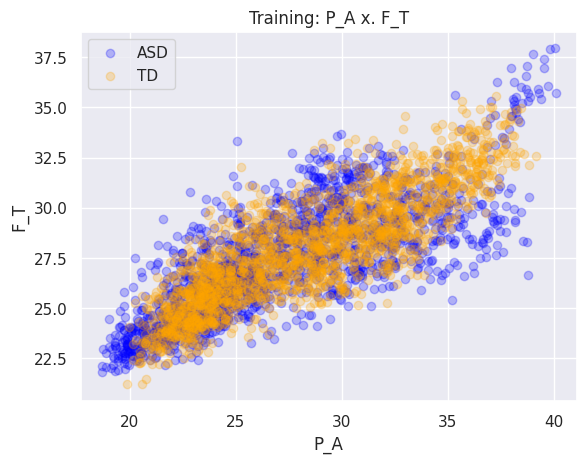

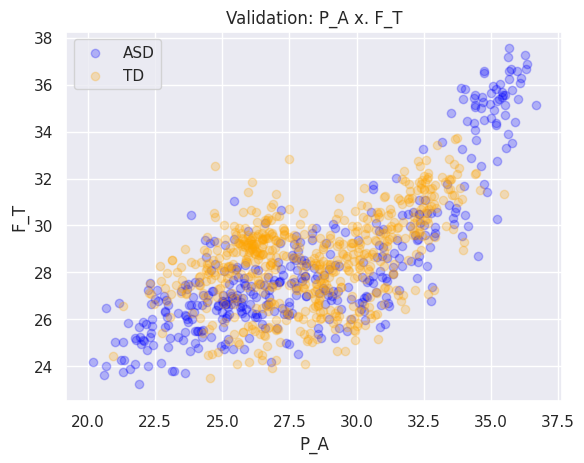

PA/FA
/////
SVC(C=5, kernel='linear')
Training acc:  0.5558283795365281
validation acc 0.6394422310756972
DecisionTreeClassifier()
Training acc:  0.5074203354762737
validation acc 0.5936254980079682
RandomForestClassifier(n_estimators=500, n_jobs=-1)
Training acc:  0.5255626459054447
validation acc 0.6245019920318725
GaussianNB()
Training acc:  0.3901306956743895
validation acc 0.6145418326693227
AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=20),
                   learning_rate=0.5, n_estimators=500)
Training acc:  0.5173154478284706
validation acc 0.6085657370517928
KNeighborsClassifier(n_neighbors=4)
Training acc:  0.4980312049524394
validation acc 0.5826693227091634
LinearDiscriminantAnalysis()
Training acc:  0.5475125469222872
validation acc 0.6633466135458167
GaussianNB()
Training acc:  0.3901306956743895
validation acc 0.6145418326693227


/tmp/ipykernel_19749/4137411037.py:189: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(X[x_axis][asd_index], X[y_axis][asd_index], c="blue", cmap=plt.cm.Paired, label="ASD", alpha=0.25)
/tmp/ipykernel_19749/4137411037.py:190: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(X[x_axis][td_index], X[y_axis][td_index], c="orange", cmap=plt.cm.Paired, label="TD", alpha=0.25)


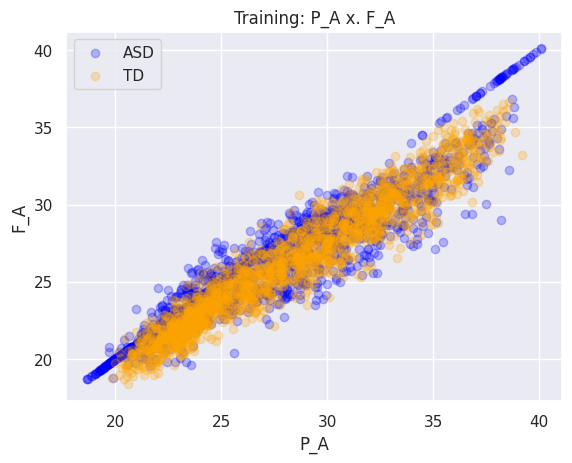

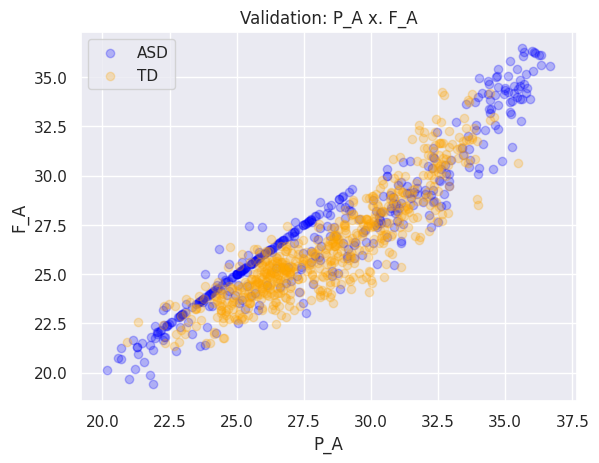

In [301]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GroupKFold,GridSearchCV,cross_val_score,cross_validate, GroupShuffleSplit, train_test_split
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVR, SVR
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingRegressor
from sklearn.naive_bayes import GaussianNB, MultinomialNB

# ML Approach
debug_asd_file_path=sorted(glob('data/asd/*.set'))
debug_td_file_path=sorted(glob('data/td/*.set'))

# https://mne.discourse.group/t/psd-multitaper-output-conversion-to-db-welch/4445
def scaleEEGPower(powerArray):
    powerArray = powerArray * 1e6**2 
    powerArray = (10 * np.log10(powerArray))
    return powerArray

# Returns and array containing band power features for each epoch. Results are averaged across all channels
def extractFetures(psd):
    #print(psd.shape)
    features = []
    for epoch in psd:
        #print(epoch.shape),
        alpha = np.mean(scaleEEGPower(epoch[:, 8:12]), axis=(1,0)) #get mean alpha value for this epoch across all channels
        delta = np.mean(scaleEEGPower(epoch[:, 0:4]), axis=(1,0))
        theta = np.mean(scaleEEGPower(epoch[:, 4:8]), axis=(1,0))
        beta = np.mean(scaleEEGPower(epoch[:, 12:30]), axis=(1,0))
        features.append([theta, delta, beta, alpha])
        #print(features)
    return features
    
def handlePSD(raw):
    psd = getPSD(raw)
    psd_np = psd.get_data() 
    features = extractFetures(psd_np)
    return features

def getAllPSDFeatures(file, interpolate_channels={}):
    raw = get_filtered_data(file, interpolate=interpolate_channels)
    return handlePSD(raw)

def getFrontalPSDFeatures(file, interpolate_channels={}):
    filtered_data = get_filtered_data(file, interpolate=interpolate_channels)
    channels_raw = getFrontalChannels(filtered_data)
    return handlePSD(channels_raw)

def getPosteriorPSDFeatures(file, interpolate_channels={}):
    filtered_data = get_filtered_data(file, interpolate=interpolate_channels)
    channels_raw = getPosteriorChannels(filtered_data)
    return handlePSD(channels_raw)

def getLeftPSDFeatures(file, interpolate_channels={}):
    filtered_data = get_filtered_data(file, interpolate=interpolate_channels)
    print(filtered_data)
    channels_raw = getLeftChannels(filtered_data)
    return handlePSD(channels_raw)

def getRightPSDFeatures(file, interpolate_channels={}):
    filtered_data = get_filtered_data(file, interpolate=interpolate_channels)
    channels_raw = getRightChannels(filtered_data)
    return handlePSD(channels_raw)

def getFeatures(file, regionExtractors, interpolate_channels={}):
    featureList = []
    for extractor in regionExtractors:
        featureList.append(extractor(file, interpolate_channels))
    return np.hstack(featureList)
    #print(len(featureList))
    #print(featureList)
    #print(o)
    #print(o.shape)

def getBasicPipeline(clf):
    return Pipeline([('scaler',StandardScaler()),('classifier',clf)])

def getFeatureLabels(extractor, regionExtractors, control_file_path, experiment_file_path, save=False, interpolate=[]):
    # Get Group IDS
    control_group_ids = [getFileID(i) for i in control_file_path]
    experiment_group_ids = [getFileID(i) for i in experiment_file_path]
    group_ids_list = control_group_ids + experiment_group_ids

    control_epochs = [extractor(subject, regionExtractors, interpolate) for subject in control_file_path] # subject, epochs, features(2) 
    experiment_epochs = [extractor(subject, regionExtractors, interpolate) for subject in experiment_file_path] # subject, epochs, features(2)
    control_epochs_labels = [len(i) * [0] for i in control_epochs]
    experiment_epochs_labels = [len(i) * [1] for i in experiment_epochs ]
    data_list = control_epochs + experiment_epochs
    label_list = control_epochs_labels + experiment_epochs_labels

    # Create array of IDs for group split that are linked to the original file ID 
    groups_list = [[group_ids_list[i]]*len(j) for i, j in enumerate(data_list)]

    data_array = np.vstack(data_list)
    label_array = np.hstack(label_list)
    group_array = np.hstack(groups_list)
    print(data_array.shape, label_array.shape,group_array.shape)
    if(save):
        # theta, delta, beta, alpha
        df = pd.DataFrame(data_array, columns = ['L_T', 'L_D', 'L_B', 'L_A', 'R_T', 'R_D', 'R_B', 'R_A', 'F_T', 'F_D', 'F_B', 'F_A', 'P_T', 'P_D', 'P_B', 'P_A'])
        df['class'] = label_array
        df['group'] = group_array
        print(df.shape)
        print(df)
        print(df['class'])
        df.to_csv('./data/dataframes/all_bands_test1.csv', index=False)
        #print(updated_data.shape)
    return [data_array, label_array, group_array] 

def evalML(data_array, label_array, group_array, pipelineFunc=getBasicPipeline, splits=5, classifier=LogisticRegression()):     
    clf=classifier
    gkf=GroupKFold(n_splits=splits)
    #param_grid = {'classifier__C': [0.01, 0.05,0.1,0.5, 1,2,3,4,5,8, 10,12,15]}
    param_grid = {}
    pipe=pipelineFunc(clf)
    gscv=GridSearchCV(pipe, param_grid, cv=gkf, n_jobs=16)
    #print("prefit", data_array.shape, label_array.shape)
    gscv.fit(data_array, label_array, groups=group_array)
    print("Training acc: ", gscv.best_score_)
    return gscv


#getFeatures(debug_td_file_path[0], [getFrontalPSDFeatures, getPosteriorPSDFeatures])

def getPolynomialPipeline(clf):
    return Pipeline(
        [
            ('scaler', StandardScaler()),
            ('classifier', clf)
        ]
    )


def testClassifiers(classifiers, train_data, train_labels, groups, test_data, test_labels):
    models = []
    for clf in classifiers:
        print(clf)
        # Train Model
        model = evalML(train_data, train_labels, groups, pipelineFunc=getPolynomialPipeline, splits=10, classifier=clf)
        models.append(model)
        # Get Validation Accuracy
        y_pred = model.predict(test_data)
        score = accuracy_score(test_labels, y_pred)
        print("validation acc", score)
    return models

def validation(x_train, y_train, x_validate, y_validate, groups):
     # SVM
    _svm = SVC(C=5, kernel='linear')

    #Decision Trees
    _d_trees = DecisionTreeClassifier()

    #Ensmble
    _rf = RandomForestClassifier(n_estimators=500,  n_jobs=-1)
    _ada = AdaBoostClassifier(
        DecisionTreeClassifier(max_depth=20), n_estimators=500, algorithm="SAMME.R", learning_rate=0.5
    )
     
    #KNN
    _knn = KNeighborsClassifier(n_neighbors=4)

    #LDA
    _lda = LinearDiscriminantAnalysis(solver='svd')

    #Narive Bayes
    _gnb = GaussianNB()

    classifiers = [_svm, _d_trees, _rf, _gnb, _ada, _knn, _lda, _gnb]

    #classifiers = [_svm]

    return testClassifiers(classifiers, x_train, y_train, groups, x_validate, y_validate)

def plot_svc(X, Y, x_axis, y_axis, model=None, title=""):
    # create a mesh to plot in
    x_min, x_max = X[x_axis].min() - 1, X[x_axis].max() + 1
    y_min, y_max = X[y_axis].min() - 1, X[y_axis].max() + 1
    h = (x_max / x_min)/100
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    fig, ax = plt.subplots()
    plt.subplot(1, 1, 1)
    asd_index = Y[:] == 0
    td_index = Y[:] == 1
    ax.scatter(X[x_axis][asd_index], X[y_axis][asd_index], c="blue", cmap=plt.cm.Paired, label="ASD", alpha=0.25)
    ax.scatter(X[x_axis][td_index], X[y_axis][td_index], c="orange", cmap=plt.cm.Paired, label="TD", alpha=0.25)
    #ax.scatter(X[td_index], X[td_index], c="orange", cmap=plt.cm.Paired, label="TD", alpha=0.25)

    ax.set(xlabel=x_axis, ylabel=y_axis)
    ax.set_xlim(xx.min(), xx.max())
    ax.set_title(f'{title} {x_axis} x. {y_axis}')
    ax.legend()
    plt.show()

def test(features):
    df = pd.read_csv('./data/dataframes/all_bands_test1.csv')
    #features = ['L_B', 'R_B']
    splitter = GroupShuffleSplit(test_size=0.2, n_splits=1, random_state=16)
    split = splitter.split(df, groups=df['group'])
    train_inds, test_inds = next(split)
    x_train = df[features].iloc[train_inds]
    x_validate = df[features].iloc[test_inds]
    y_train = df['class'].iloc[train_inds]
    y_validate = df['class'].iloc[test_inds]
    groups = df['group'].iloc[train_inds]

    #print(x_train.shape, y_train.shape, x_validate.shape, y_validate.shape, groups.shape)
    models = validation(x_train, y_train, x_validate, y_validate, groups)

    return x_train, y_train, x_validate, y_validate, models


def test_with_plot(features):
    x_train, y_train, x_validate, y_validate, models = test(features)    
    plot_svc(x_train, y_train, features[0], features[1], title="Training:")
    plot_svc(x_validate, y_validate, features[0], features[1], title="Validation:")

def main():
    #region_labels = ["F", "R", "L", "P", "PR", "PF", "LR", "ALL"]
    #region_labels = ["PR", "PF", "LR", "ALL"]

    '''
    regions = [
        [getPosteriorPSDFeatures, getFrontalPSDFeatures],
        [getLeftPSDFeatures, getRightPSDFeatures],
    ]
    '''

    # Pass interpolate channel through to add interpolate step into the existing pipeline
    _interpolate_channels = {
        '24': ['CP3', 'P2'],
        '42': ['TP8', 'TP7', "T7"],
        '49': ['T8'],
        '11': ['F5', 'F7', 'FT7', 'FC5', 'T7'],
        '12': ['C5', 'T7', 'TP7'],
        '13': ['FC6'],
        '18': ['FC3'],
        '20': ['T7'],
        '21': ['T7', 'T8', 'P2'],
        '27': ['P10'],
        '28': ['C3'],
        '5': ['F7', 'FT7']
    }

    regions = [
        [getLeftPSDFeatures, getRightPSDFeatures, getFrontalPSDFeatures, getPosteriorPSDFeatures],
    ]

    region_labels = ["LR"]
    for idx, region in enumerate(regions): 
        data_array, label_array, group_array = getFeatureLabels(getFeatures, region, debug_td_file_path, debug_asd_file_path, True, _interpolate_channels)
        #print("Region: ", region_labels[idx])
        #evalLogisticRegressionML(data_array, label_array, group_array, 2)

#main()
# Delta and Beta Seem INteresting
#print("P/F B/D")
#print("/////")
#test(['P_B','P_D', "F_B", 'F_D'])

# T/A in P/F also seems interesting

'''
print("P/F - T/A")
print("/////")
test(['P_T','P_A', "F_T", 'F_A'])
print("PT/PA")
print("/////")
test_with_plot(["P_T", "P_A"])
print("FT/FA")
print("/////")
test_with_plot(["F_T", "F_A"])
print("PT/FT")
print("/////")
test_with_plot(["P_T", "F_T"])
print("PT/FA")
print("/////")
test_with_plot(["P_T", "F_A"])
print("PA/FT")
print("/////")
test_with_plot(["P_A", "F_T"])
print("PA/FA")
print("/////")
test_with_plot(["P_A", "F_A"])
'''


###
#print("L/R -B/D | P/F - A/B")
#print("/////")
#test(['L_B','L_D', "R_B", 'R_D', 'P_T','P_A', "F_T", 'F_A'])



In [ ]:
    #validation(x_train, y_train, x_test, y_test, groups)

    #print("train: ", train_data['group'].value_counts())
    #print("test: ", test_data['group'].value_counts())
    #print(train_data.shape, test_data.shape)



    # TODO
    # Group Splits so that groups in the test set do not apprear in the train/validation set (1) 
    # Pass train_validation split data to the cross validation test (2)
    
    #X_train_validate, X_test, y_train_validate, y_test = train_test_split(X, Y, test_size=0.33, random_state=101, stratify=Y)
    #X_train, X_validate, y_train, y_validate = train_test_split(X_train_validate, y_train_validate, test_size=0.33, random_state=201, stratify=X_train_validate['group'])

    # Prepare Data
    #X_train_data = X_train.iloc[:, :-2] # remove labels and groups
    #X_validate_data = X_validate.iloc[:, :-2] # remove labels and groups
    #X_Groups = X_train.iloc[:, [-1]]
   
    #print(y_train.value_counts())
    #print(y_validate.value_counts())

    #validation(X_train_data, y_train, X_validate_data, y_validate, X_Groups)

    #print("test ", y_test.value_counts())
    #print(y_train.value_counts(), y_validate.value_counts())
    #print(X)
    #print(y_train.value_counts())
    #print(X_train)
    #splitter = GroupShuffleSplit(test_size=0.2, n_splits=5, random_state=7)
    #print(X_train_validate['group'])
    #print(X_train_validate.shape)
    #("X_train_validate original shape", X_train_validate.shape)
    #split = splitter.split(X_train_validate, groups=X_train_validate['group'])
    # train_inds, test_inds = next(split)

    # Training and Validation Loop
    '''
    for train_inds, test_inds in splitter.split(X_train_validate, groups=X_train_validate['group']):
        _train, _counts = np.unique(X_train_validate.iloc[train_inds]['group'], return_counts=True)
        print("train groups", _train)
        _test, _counts = np.unique(X_train_validate.iloc[test_inds]['group'], return_counts=True)
        print("test groups", _test)
    '''

    # Testing Loop

    #_train, counts = np.unique(X_train_validate.iloc[train_inds]['class'], return_counts=True)
    #print(_train, counts)
    #X_train_test = df.iloc[train_inds]
    #X = X_train_test.iloc[:, :-2]
    #Y = X_train_test.iloc[:, [-2]]
    #print(X)
    #print(Y)
    #X_train, X_validate, y_train, y_validate = train_test_split(X,Y,random_state=101, stratify=Y)
    #print(y_train.value_counts())
    #print(y_validate.value_counts())
    #_train, counts = np.unique(df.iloc[train_inds]['class'], return_counts=True)
    #print(_train, counts)
    #print(np.unique(df[train_inds]['group']), np.unique(df[test_inds]['group']))
    #print(df.shape)
    #patient_cutoff = 23
    #control_cutoff = 49
    #data_array_train = df[((df['class'] == 0) & (df['group'] < patient_cutoff)) | ((df['class'] == 1) & (df['group'] < control_cutoff))]
    #data_array_test = df[((df['class'] == 0) & (df['group'] >= patient_cutoff)) | ((df['class'] == 1) & (df['group'] >= control_cutoff))]
    features = ['F_B', 'L_B', 'R_B', 'P_B']
    #print(data_array_test)
    #df = data_array_train
    #data_array = df[['L_T', 'L_D', 'L_B', 'L_A', 'R_T', 'R_D', 'R_B', 'R_A']]
    #data_array = df[features]
    #print("train array", data_array.shape)
    #label_array = df['class']
    #print("train label array", np.unique(label_array))
    #group_array = df['group']
    #print(data_array.shape)
    #print(data_array, label_array, group_array)

    #test_data_array = data_array_test[['L_T', 'L_D', 'L_B', 'L_A', 'R_T', 'R_D', 'R_B', 'R_A']]
    #test_data_array = data_array_test[features]
    #print("test_data_array.shape", test_data_array.shape)
    #test_label_array = data_array_test['class']
    #print("test label array", np.unique(test_label_array))
    #test_group_array =  data_array_test['group']
    #print(test_group_array)
 
   
    '''
    model = evalML(data_array, label_array, group_array, pipelineFunc=getPolynomialPipeline, splits=5, classifier=_gbr)
    print("test")
    y_pred = model.predict(test_data_array)
    score = accuracy_score(test_data_array, y_pred)
    print(score)
    '''

    
    #classifiers = [_svm]

    #testClassifiers(classifiers, data_array, label_array, group_array, test_data_array, test_label_array)

# Adding Channel Interpolation to the Pipeline

See [https://mne.tools/dev/auto_tutorials/preprocessing/15_handling_bad_channels.html](https://mne.tools/dev/auto_tutorials/preprocessing/15_handling_bad_channels.html)

1. Remove bad files from data folder
2. Add bad channel interpolation right before ICA
3. Create a function that takes a signal and returns the signal with bad channels interpolated (e.g., fix_bad_channels())



# Files Removed 
### TD drops
30, 31, 32, 33, 45, 55, 56

### ASD Drops
17, 19, 22, 28, 29, 3, 8,


In [ ]:
# Testing function to interpolate channels

def get_filtered_data2(file_path, l_freq = 0.5, h_freq = 40):
    print(file_path)
    raw = mne.io.read_raw_eeglab(file_path, preload=True)
    raw.set_eeg_reference()
    #epochs = mne.make_fixed_length_epochs(raw, duration=1, overlap=0, preload=True)
    #print(epochs.get_data().shape)
    eeg_data_interp = fix_bad_channels(raw, ['F7'])
    for title, data in zip(["orig.", "interp."], [raw, eeg_data_interp]):
        with mne.viz.use_browser_backend("matplotlib"):
            fig = data.plot()
        fig.subplots_adjust(top=0.9)
        fig.suptitle(title, size="xx-large", weight="bold")

def load_file_manual(type, id):
    file = f'data/{type}/{id}Abby_Resting.set'
    p = get_filtered_data2(file)

#load_file_manual("td", 24)




In [ ]:
# This may be usefor getting the 1/f exponent

import matplotlib.pyplot as plt

x = np.array([1, 2])
y = np.array([2, 4])

plt.plot(x, y, 'o')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

import numpy as np
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(x.reshape(-1, 1), y)

slope = model.coef_[0]

print(slope)



In [ ]:
# Asymmetry


# (Page 10) Li Q, Weiland R F, Konvalinka I, Mansvelder H D, Andersen T S, Smit D J A, Begeer S and Linkenkaer-Hansen K 2022 Intellectually able adults with autism spectrum disorder show typical resting-state EEG activity Sci Rep-uk 12 19016
EEG power asymmetry was calculated by subtracting each left hemispheric patch from the corresponding 
patch in the right hemisphere 77, followed by averaging across the brain regions.

# EEGLAB Listserv:
> Hi all. In order to compute EEG asymmetry on resting state datasets I use
> the EEGlab toolbox spectopo function, so I get the spectra in dB for each
> frequency, then I calculate absolute power (with the formula
> 10^10(spetra)/10) and a mean of this absolute power for each electrode in
> the alpha band. I then calculate asymmetry log(absolute power
> F4)-log(absolute power F3) to calculate the index, or even using a mean of
> absolute power for groups of electrodes. Do you think that is the right?
> Does the calculation of asymmetry index requires the use of absolute power?



In [ ]:
# Connectivity

# https://mne.tools/mne-connectivity/stable/generated/mne_connectivity.spectral_connectivity_epochs.html#mne_connectivity.spectral_connectivity_epochs
# https://mne.tools/mne-connectivity/stable/auto_examples/dpli_wpli_pli.html#sphx-glr-auto-examples-dpli-wpli-pli-py


In [ ]:
# Prepare Data Frame for plotting PSD

df = pd.DataFrame({})
regions_id = ["frontal", "central", "posterior", "left", "right"]

groups = [{"data": asd_files, "group_id": "ASD"}, {"data": td_files, "group_id": "TD"}]

# Find a better way to format this at some point. Nested loops are very slow
# Prepare data frame to plot PSD comparison
for type_id, group in enumerate(groups):
    for subject_id, subject in enumerate(group['data']):
        print(subject_id/len(group['data']))
        frontal, central, posterior, left, right, all = split(subject)
        regions = [frontal, central, posterior, left, right]
        for id_region, region in enumerate(regions):
            psd = getPSD(region)
            psd_np = psd.get_data()
            _psd = np.mean(psd_np, axis=(0))
            for id_channel, channel in enumerate(_psd):
                for id_freq, sample in enumerate(channel):
                    # Data type, Subject ID, Brain Region, Channel Name, Freq Bin, Sample
                    #print(data_type, subject_id, brain_region, frontal.ch_names[idx], idj, sample)
                    new_row = pd.DataFrame.from_records([{
                        "Type":group["group_id"],  
                        "Subject": subject_id,
                        "Region": regions_id[id_region],
                        "Channel": region.ch_names[id_channel],
                        "Freq": id_freq,
                        "Sample": sample
                    }])
                    df = pd.concat([df, new_row])
                    
filepath = Path('data/asd_td_3.csv')  
filepath.parent.mkdir(parents=True, exist_ok=True)
df.to_csv(filepath, index=False) 

In [ ]:
# Selecting subset example (PANDAS)

# https://pandas.pydata.org/docs/getting_started/intro_tutorials/03_subset_data.html
#df = pd.read_csv(filepath) 
#display(df)
#df = df[(df["Freq"] < 12) & (df["Freq"] > 8)]display(df)


# Type, Subject, Region, Channel, Band, Value
#sns.lineplot(data=df, x="Freq", y="Sample", hue="Type")
#plt.show()

In [ ]:
# MISC

# Creating Feature Structure


def getTotalSubjects(groups):
    subject_count = 0
    for i in groups:
        subject_count += len(i["data"])
    return subject_count

def extractFetures(signal):
    delta = np.mean(signal[:4])
    theta = np.mean(signal[4:8])
    alpha = np.mean(signal[8:12])
    beta = np.mean(signal[13:30])
    gamma = np.mean(signal[30:40])
    return [gamma]

def extractRegionFeatures(epoch, ranges=[[1,4], [8,12]]):
    psd = getPSD(epoch)
    epochs_features = []
    psd_np = psd.get_data()

    for i in ranges:
        #print(i)
        band = scaleEEGPower(psd_np[:, :, i[0]:i[1]])
        band_channel_mean = np.mean(band, axis=(1, 2)) # average across channels
        #print(band_channel_mean)
        #print(band_channel_mean.shape)
        epochs_features.append(band_channel_mean)
        #alpha_reshape = alpha.reshape(95, -1)
        #print(alpha_reshape.shape)
        #print(alpha_reshape)
    return np.stack(epochs_features, axis=1)

regions_id = ["frontal", "central", "posterior", "left", "right"]
groups = [{"data": asd_files, "group_id": "ASD"}, {"data": td_files, "group_id": "TD"}]
frontal, central, posterior, left, right, all = split(groups[0]['data'][0])
featureCount = 2
regions = [frontal, central, posterior, left, right]
regionCount = len(regions)
epochs = len(frontal)
X_2d = np.empty([epochs, regionCount, featureCount], dtype=float)
print("X_2d", X_2d.shape)



def main():
    x = []
    for region_id, region_epoch in enumerate(regions):
        x.append(extractRegionFeatures(region_epoch))
    t = np.stack(x, axis=1)
    print(t.shape)
    print(t)

main()


# Misc

print(len(asd_files))
print(len(td_files))

def channel_in_file(channel, file_path):
    #print("loading", file_path)
    datax=mne.io.read_raw_eeglab(file_path,preload=True)
    return channel in datax.ch_names

def checkChannels(channels, file_path):
  results = []
  for idx, channel in enumerate(channels):
    results.append(0)
    for file in file_path: 
      print(file)
      results[idx] += channel_in_file(channel, file)
      print(results)


#ASD
#channels = np.array(['Fp1', 'AF7', 'AF3', 'F1', 'F3', 'F5', 'F7', 'FT7', 'FC5', 'FC3', 'FC1', 'C1', 'C3', 'C5', 'T7', 'TP7', 'CP5', 'CP3', 'CP1', 'P1', 'P3', 'P5', 'P7', 'P9', 'PO7', 'PO3', 'O1', 'Iz', 'Oz', 'POz', 'Pz', 'CPz', 'Fpz', 'Fp2', 'AF8', 'AF4', 'AFz', 'Fz', 'F2', 'F4', 'F6', 'F8', 'FT8', 'FC6', 'FC4', 'FC2', 'FCz', 'C2', 'C4', 'C6', 'T8', 'TP8', 'CP6', 'CP4', 'CP2', 'P2', 'P4', 'P6', 'P8', 'P10', 'PO8', 'PO4', 'O2'])
#channel_count = np.array([27, 27, 26, 25, 25, 24, 27, 24, 26, 23, 26, 23, 26, 26, 18, 23, 23, 25, 25, 27, 25, 26, 23, 27, 26, 26, 27, 24, 25, 27, 26, 25, 26, 27, 25, 24, 24, 26, 26, 22, 24, 25, 22, 21, 24, 24, 25, 23, 24, 22, 20, 23, 26, 26, 24, 27, 24, 24, 26, 27, 25, 25, 27])
#greater_25 = ['Fp1', 'AF7', 'AF3', 'F7', 'FC5', 'FC1', 'C3', 'C5', 'P1', 'P5', 'P9', 'PO7', 'PO3', 'O1', 'POz', 'Pz', 'Fpz', 'Fp2', 'Fz', 'F2', 'CP6', 'CP4', 'P2', 'P8', 'P10', 'O2']
#output = channels[channel_count > 25]
#print(output)
#checkChannels(channels, asd_file_path)

def read_data(file_path):
    pass
    #print("loading", file_path)
    #raw = mne.io.read_raw_eeglab(file_path,preload=True)
    #return raw
    #epochs=mne.make_fixed_length_epochs(datax,duration=1,overlap=0, preload=True)
    #print("original ", epochs.ch_names)
    #epochs.pick_channels(['Fp1', 'Fpz', 'Fp2', 'O1', 'Oz', 'O2', 'Fz', 'FCz'])

    '''
    datax.set_eeg_reference()
    datax.filter(l_freq=1,h_freq=45)
    epochs=mne.make_fixed_length_epochs(datax,duration=1,overlap=0)
    epochs_np=epochs.get_data()
    return epochs, epochs_np #trials,channel,length
    '''



In [ ]:
    '''
    for i in range(10):    
    train_inds, test_inds = next(split)
    unique, counts = np.unique(self.groups[train_inds], return_counts=True)

    _o = dict(zip(unique, counts))
    print("train: ", _o)

    unique, counts = np.unique(self.groups[test_inds], return_counts=True)
    _o = dict(zip(unique, counts))
    print("test: ", _o)
                        
    '''


    '''
    splitter = GroupShuffleSplit(test_size=test_size, n_splits=n_splits, random_state=random_state)
    split = splitter.split(df, groups=df['group'])
    train_inds, test_inds = next(split)
    train = df.iloc[train_inds]
    test = df.iloc[test_inds]
    print(train[:,:])
    '''


    #print("train ", len(train[(train['group'] == _group_id)]))
    #print("test ",len(test[(test['group'] == _group_id)]))
    #print(test['group'])
    

    
    '''
    xy = np.loadtxt(file_path, delimiter=',', dtype=np.float32, skiprows=1)
    self.x_data = torch.from_numpy(xy[:, :-2]) # size [n_samples, n_features]
    self.y_data = torch.from_numpy(xy[:, [-2]]) # size [n_samples, 1]
    self.group_data = torch.from_numpy(xy[:, [-1]])
    print(xy.shape)
    gkf = GroupKFold(n_splits=2)

    for train_index, test_index in gkf.split(self.x_data, self.y_data, groups=self.group_data):
        print(self.group_data[train_index].shape, self.group_data[test_index].shape)
        unique, counts = np.unique(self.group_data[train_index], return_counts=True)

        _o = dict(zip(unique, counts))
        print("train: ", _o)

        unique, counts = np.unique(self.group_data[test_index], return_counts=True)
        _o = dict(zip(unique, counts))
        print("test: ", _o)
    '''


    ''' 
    df = pd.read_csv(file_path) 
    #print("df ", df.shape)
    _group_id = 10
    _g = len(df[(df['group'] == _group_id)]['group'])

    print(_g)
    g_k_f =  GroupKFold(n_splits=2)

    for i, (train_index, test_index) in enumerate(g_k_f.split(X, y, groups)):
    '''